# ARIMA for Anomaly Detection in Time Series Data

## Import libraries

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
import joblib
from itertools import product
from pathlib import Path
from statsmodels.tsa.seasonal import STL
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import f1_score, precision_score, recall_score,roc_auc_score, confusion_matrix, roc_curve, auc

## ARIMA for conductivity

### Hierachical training method

In [ ]:
# -----------------------------------------------
# 1. LOAD AND PREPARE YOUR DATASET
# -----------------------------------------------

# Path to data folder
data_path = Path.cwd()/'Datasets'

# Path from data folder to the data file
train_c_filename = 'train_c_data.xlsx'
valid_c_filename = 'valid_c_data.xlsx'
test_c_filename = 'test_c_data.xlsx'

# import data file
train_c = pd.read_excel(data_path/train_c_filename)
valid_c = pd.read_excel(data_path/valid_c_filename)
test_c = pd.read_excel(data_path/test_c_filename)

# Extract consuctivity data
train_conduct = train_c[['index', 'conductivity', 'run_id', 'timestamp']].copy()
valid_conduct = valid_c[['index', 'conductivity', 'run_id', 'anomaly_label', 'timestamp']].copy()
test_conduct = test_c[['index', 'conductivity', 'run_id', 'anomaly_label', 'timestamp']].copy()

C:\Users\kittyoomm\AppData\Local\Temp\ipykernel_9780\3557667906.py:3: UserWarning: The palette list has more values (6) than needed (5), which may not be intended.
  ax1 = sns.lineplot(data=train_conduct, x='index', y='conductivity', hue='run_id', palette=sns.color_palette("viridis"), ax=ax[0])
C:\Users\kittyoomm\AppData\Local\Temp\ipykernel_9780\3557667906.py:9: UserWarning: The palette list has more values (6) than needed (2), which may not be intended.
  ax2 = sns.lineplot(data=valid_conduct, x='index', y='conductivity', hue='run_id', palette=sns.color_palette("viridis"), ax=ax[1])
C:\Users\kittyoomm\AppData\Local\Temp\ipykernel_9780\3557667906.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  anomalies_labeled['anomaly_label'] = ['Labeled 

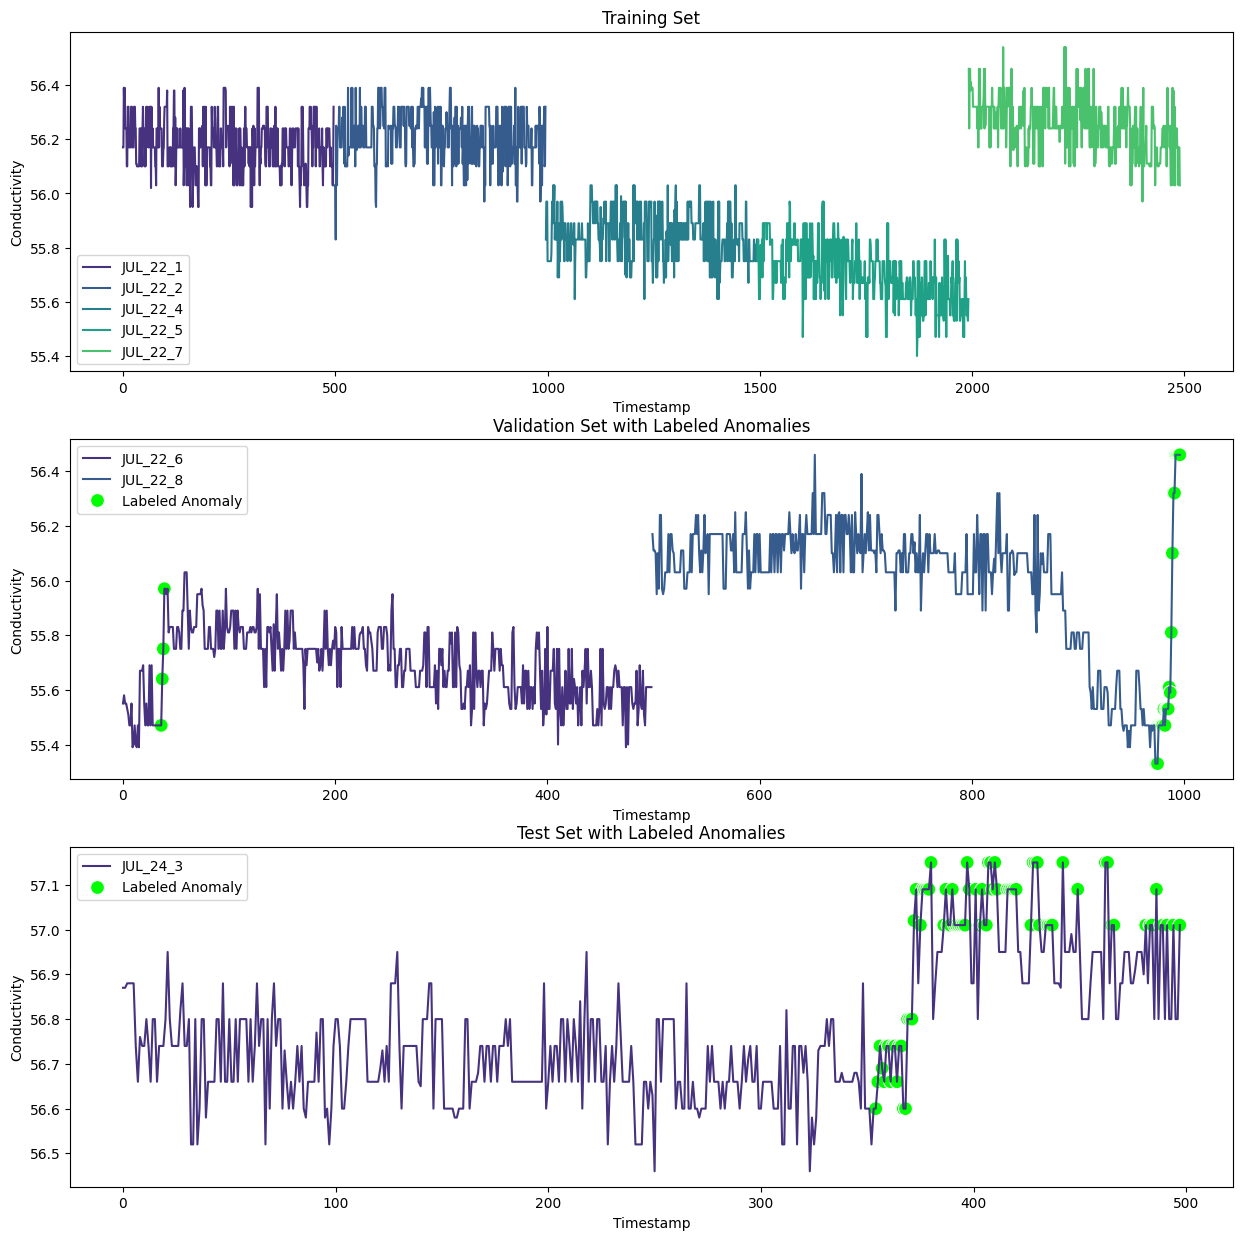

In [4]:
# Dataset overview plots
fig, ax = plt.subplots(3, 1, figsize=(15, 15))
ax1 = sns.lineplot(data=train_conduct, x='index', y='conductivity', hue='run_id', palette=sns.color_palette("viridis"), ax=ax[0])
ax1.set_title('Training Set')
ax1.set_xlabel('Timestamp')
ax1.set_ylabel('Conductivity')
ax1.legend()

ax2 = sns.lineplot(data=valid_conduct, x='index', y='conductivity', hue='run_id', palette=sns.color_palette("viridis"), ax=ax[1])
anomalies_labeled = valid_conduct[valid_conduct['anomaly_label'] == 1]
anomalies_labeled['anomaly_label'] = ['Labeled Anomaly']*len(anomalies_labeled)
ax2 = sns.scatterplot(data=anomalies_labeled, x='index', y='conductivity', color='lime', style='anomaly_label', markers='o', s=100, legend='full', ax=ax[1])
ax2.set_title('Validation Set with Labeled Anomalies')
ax2.set_xlabel('Timestamp')
ax2.set_ylabel('Conductivity')
ax2.legend()

ax3 = sns.lineplot(data=test_conduct, x='index', y='conductivity', hue='run_id', palette=sns.color_palette("viridis"), ax=ax[2])
anomalies_labeled = test_conduct[test_conduct['anomaly_label'] == 1]
anomalies_labeled['anomaly_label'] = ['Labeled Anomaly']*len(anomalies_labeled)
ax3 = sns.scatterplot(data=anomalies_labeled, x='index', y='conductivity', color='lime', style='anomaly_label', markers='o', s=100, legend='full', ax=ax[2])
ax3.set_title('Test Set with Labeled Anomalies')
ax3.set_xlabel('Timestamp')
ax3.set_ylabel('Conductivity')
ax3.legend()

plt.show()

In [5]:
# Function to standardize data
def parse_and_standardize(df: pd.DataFrame, scaler: StandardScaler = None, parameter: str = train_conduct.columns[1]) -> StandardScaler:
    #df['timestamp'] = pd.to_datetime(df['timestamp'])
    df['stand_value'] = df[parameter]
    if not scaler:
        scaler = StandardScaler()
        scaler.fit(df['stand_value'].values.reshape(-1, 1))
    df['stand_value'] = scaler.transform(df['stand_value'].values.reshape(-1, 1))
    return scaler

In [6]:
data_scaler = parse_and_standardize(df=train_conduct, parameter='conductivity')
parse_and_standardize(df=valid_conduct, scaler=data_scaler, parameter='conductivity')
parse_and_standardize(df=test_conduct, scaler=data_scaler, parameter='conductivity')    

,copy,True
,with_mean,True
,with_std,True


In [7]:
# --- MAPPING AND CLEANING FUNCTION ---
def preprocess_data(df, fe_cols_to_keep=None):
    # Rename columns to standard names
    df = df.rename(columns={
        'timestamp': 'Date',
        'run_id': 'Run_ID',
        'stand_value': 'Conductivity_Standardized',
    })
    df['Date'] = pd.to_datetime(df['Date'])
    df = df.set_index('Date')
    df.sort_values(by=['Run_ID', 'Date'], inplace=True)

    # Create ALL possible Fixed Effect (FE) Dummies, including the column for the first run
    run_dummies = pd.get_dummies(df['Run_ID'], prefix='Run_FE', dtype=int)
    
    # If this is the validation step, we need to ensure it has all FE columns
    if fe_cols_to_keep is not None:
        # Reindex to match the columns trained by the model
        df_fe = run_dummies.reindex(columns=fe_cols_to_keep, fill_value=0)
    else:
        # For training, determine the FE columns and drop the first one as the baseline
        # We need to explicitly exclude one to serve as the baseline intercept (Constant)
        fe_cols = run_dummies.columns
        df_fe = run_dummies.drop(columns=[fe_cols[0]]) # Drop the first FE column as baseline
        
    df_processed = pd.concat([df, df_fe], axis=1)

    # Separate endog (y) and exog (X)
    endog = df_processed['Conductivity_Standardized']
    exog = df_fe # This is the FE matrix we need for SARIMAX
    
    return endog, exog, df_processed

In [8]:
# --- Preprocess Training Data ---
y_train, X_train, df_train = preprocess_data(train_conduct, fe_cols_to_keep=None)

# Store the final list of FE columns used in training (excluding the baseline FE)
trained_fe_cols = X_train.columns

# Preprocess the validation set, ensuring its FE matrix matches the training model
y_valid, X_valid, df_valid_processed = preprocess_data(valid_conduct, fe_cols_to_keep=trained_fe_cols)

# Preprocess the test set, ensuring its FE matrix matches the training model
y_test, X_test, df_test_processed = preprocess_data(test_conduct, fe_cols_to_keep=trained_fe_cols)

In [9]:
# -----------------------------------------------
# 2. FIT THE HIERARCHICAL TIME SERIES MODEL
# -----------------------------------------------

# Define the ARIMA/SARIMA order parameters:
# (p, d, q) for ARIMA terms, (P, D, Q, s) for Seasonal terms
import pmdarima as pm

# The auto_arima function handles the grid search and AIC minimization automatically
model_auto = pm.auto_arima(
    y=y_train,              # The training parameter values
    exogenous=X_train,      # The Fixed Effect Dummies
    start_p=1, max_p=3,     # Range for non-seasonal AR
    start_q=1, max_q=3,     # Range for non-seasonal MA
    d=None, D=None,         # Let the function decide the differencing (d)
    seasonal=False, # Set seasonal=True and define your seasonal period 's_val'
    trace=True,             # Print results for each iteration
    error_action='ignore',
    suppress_warnings=True,
    stepwise=True           # Speeds up the search
)

# The optimal orders are then stored in model_auto.order and model_auto.seasonal_order
order_params = model_auto.order
seasonal_params = model_auto.seasonal_order # No seasonal components

print(f"Fitting SARIMAX model with order={order_params}, seasonal_order={seasonal_params} and Fixed Effects...")

try:
    Hier_model = sm.tsa.statespace.SARIMAX(
        endog=y_train,
        exog=X_train,
        order=order_params,
        seasonal_order=seasonal_params,
        enforce_stationarity=False,
        enforce_invertibility=False 
    )

    Hier_results = Hier_model.fit(disp=False)
    print("\n--- SARIMAX Model Fitting Complete ---")
    
except Exception as e:
    print(f"SARIMAX Model fitting failed: {e}")
    exit()

c:\Users\kittyoomm\Desktop\Work@MTEC\PlateMon_data_analytics\.venv\Lib\site-packages\sklearn\utils\deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\kittyoomm\Desktop\Work@MTEC\PlateMon_data_analytics\.venv\Lib\site-packages\sklearn\utils\deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\kittyoomm\Desktop\Work@MTEC\PlateMon_data_analytics\.venv\Lib\site-packages\sklearn\utils\deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\kittyoomm\Desktop\Work@MTEC\PlateMon_data_analytics\.venv\Lib\site-packages\sklearn\utils\deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\kittyoomm\Desktop\Work@MTEC\Pla

Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=2275.177, Time=0.57 sec


c:\Users\kittyoomm\Desktop\Work@MTEC\PlateMon_data_analytics\.venv\Lib\site-packages\sklearn\utils\deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=3116.447, Time=0.31 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=2546.977, Time=0.20 sec


c:\Users\kittyoomm\Desktop\Work@MTEC\PlateMon_data_analytics\.venv\Lib\site-packages\sklearn\utils\deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\kittyoomm\Desktop\Work@MTEC\PlateMon_data_analytics\.venv\Lib\site-packages\sklearn\utils\deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=2279.162, Time=0.26 sec


c:\Users\kittyoomm\Desktop\Work@MTEC\PlateMon_data_analytics\.venv\Lib\site-packages\sklearn\utils\deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(0,1,0)(0,0,0)[0]             : AIC=3114.448, Time=0.31 sec


c:\Users\kittyoomm\Desktop\Work@MTEC\PlateMon_data_analytics\.venv\Lib\site-packages\sklearn\utils\deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=2172.289, Time=0.49 sec


c:\Users\kittyoomm\Desktop\Work@MTEC\PlateMon_data_analytics\.venv\Lib\site-packages\sklearn\utils\deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=2220.083, Time=0.48 sec


c:\Users\kittyoomm\Desktop\Work@MTEC\PlateMon_data_analytics\.venv\Lib\site-packages\sklearn\utils\deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=2174.204, Time=1.75 sec


c:\Users\kittyoomm\Desktop\Work@MTEC\PlateMon_data_analytics\.venv\Lib\site-packages\sklearn\utils\deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=2174.057, Time=1.34 sec


c:\Users\kittyoomm\Desktop\Work@MTEC\PlateMon_data_analytics\.venv\Lib\site-packages\sklearn\utils\deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=2227.230, Time=1.11 sec


c:\Users\kittyoomm\Desktop\Work@MTEC\PlateMon_data_analytics\.venv\Lib\site-packages\sklearn\utils\deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=2187.450, Time=0.38 sec


c:\Users\kittyoomm\Desktop\Work@MTEC\PlateMon_data_analytics\.venv\Lib\site-packages\sklearn\utils\deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=2024.134, Time=2.47 sec


c:\Users\kittyoomm\Desktop\Work@MTEC\PlateMon_data_analytics\.venv\Lib\site-packages\sklearn\utils\deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(3,1,3)(0,0,0)[0] intercept   : AIC=1977.931, Time=3.20 sec


c:\Users\kittyoomm\Desktop\Work@MTEC\PlateMon_data_analytics\.venv\Lib\site-packages\sklearn\utils\deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(2,1,3)(0,0,0)[0] intercept   : AIC=2161.543, Time=1.97 sec


c:\Users\kittyoomm\Desktop\Work@MTEC\PlateMon_data_analytics\.venv\Lib\site-packages\sklearn\utils\deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(3,1,3)(0,0,0)[0]             : AIC=1971.422, Time=1.06 sec


c:\Users\kittyoomm\Desktop\Work@MTEC\PlateMon_data_analytics\.venv\Lib\site-packages\sklearn\utils\deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(2,1,3)(0,0,0)[0]             : AIC=2159.547, Time=0.58 sec


c:\Users\kittyoomm\Desktop\Work@MTEC\PlateMon_data_analytics\.venv\Lib\site-packages\sklearn\utils\deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(3,1,2)(0,0,0)[0]             : AIC=2022.144, Time=0.88 sec


c:\Users\kittyoomm\Desktop\Work@MTEC\PlateMon_data_analytics\.venv\Lib\site-packages\sklearn\utils\deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(2,1,2)(0,0,0)[0]             : AIC=2172.058, Time=0.41 sec

Best model:  ARIMA(3,1,3)(0,0,0)[0]          
Total fit time: 17.808 seconds
Fitting SARIMAX model with order=(3, 1, 3), seasonal_order=(0, 0, 0, 0) and Fixed Effects...


c:\Users\kittyoomm\Desktop\Work@MTEC\PlateMon_data_analytics\.venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\kittyoomm\Desktop\Work@MTEC\PlateMon_data_analytics\.venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)



--- SARIMAX Model Fitting Complete ---


c:\Users\kittyoomm\Desktop\Work@MTEC\PlateMon_data_analytics\.venv\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


In [10]:
# Store the prediction of the training set
train_conduct['Prediction'] = Hier_results.fittedvalues.reset_index(drop=True)
train_conduct['Predicted_conductivity'] = data_scaler.inverse_transform(train_conduct['Prediction'].values.reshape(-1, 1)) 
train_conduct

,index,conductivity,run_id,timestamp,stand_value,Prediction,Predicted_conductivity
0,0,56.17,JUL_22_1,2025-07-22 13:21:01,0.538548,0.000000,56.039518
1,1,56.17,JUL_22_1,2025-07-22 13:21:03,0.538548,0.570969,56.177855
2,2,56.39,JUL_22_1,2025-07-22 13:21:05,1.446572,0.425012,56.142492
3,3,56.32,JUL_22_1,2025-07-22 13:21:07,1.157655,1.581385,56.422663
4,4,56.39,JUL_22_1,2025-07-22 13:21:09,1.446572,0.737238,56.218139
...,...,...,...,...,...,...,...
2485,2485,56.17,JUL_22_7,2025-07-22 16:34:50,0.538548,0.568822,56.177335
2486,2486,56.03,JUL_22_7,2025-07-22 16:34:52,-0.039285,0.573266,56.178412
2487,2487,56.17,JUL_22_7,2025-07-22 16:34:54,0.538548,0.451106,56.148814
2488,2488,56.17,JUL_22_7,2025-07-22 16:34:56,0.538548,0.430966,56.143935


In [11]:
# Assuming 'h' is the length of your validation set (len(y_valid))
# and X_valid is your exogenous matrix.

# Use get_forecast()
start_idx = len(y_train) 
end_idx = start_idx + y_valid - 1
forecast_result = Hier_results.predict(len(y_valid), exog=X_valid)

# Extract the predicted value (the mean)
predicted_value = forecast_result

In [12]:
forecast_result

Date
2025-07-22 14:54:54   -1.118194
2025-07-22 14:54:57   -0.604497
2025-07-22 14:54:59   -0.665618
2025-07-22 14:55:01   -0.776294
2025-07-22 14:55:03   -0.922868
                         ...   
2025-07-22 16:34:50    0.568822
2025-07-22 16:34:52    0.573266
2025-07-22 16:34:54    0.451106
2025-07-22 16:34:56    0.430966
2025-07-22 16:34:58    0.450212
Name: predicted_mean, Length: 1493, dtype: float64

In [13]:
# ----------------------------------------------------
# 3. CALCULATE AND APPLY RUN-SPECIFIC OFFSETS
# ---------------------------------------------------

# --- Define the Lookback Window ---
# This is the number of initial data points used to estimate the new run's baseline
WINDOW_SIZE = 60

# --- Prepare Validation Data for Iteration ---
valid_conduct['Residual'] = np.nan # Placeholder for the final residual
valid_conduct['Predicted_conductivity'] = np.nan # Placeholder for the final adjusted prediction

print("\nCalculating run-specific baseline offsets for validation runs...")

# Iterate through each unseen Run_ID in the validation set
for run_id, run_data in valid_conduct.groupby('run_id'):
    
    # 1. Setup indices and data for the current run
    run_len = len(run_data)
    
    # Indices for prediction (start immediately after training ends)
    start_idx = len(y_train) 
    end_idx = start_idx + run_len - 1
    
    # Isolate the exogenous data for this specific run
    X_run = X_valid.iloc[run_data.index, :] 

    # 2. Generate RAW Prediction (using the common intercept)
    raw_run_forecast = Hier_results.get_prediction(
        start=start_idx, 
        end=end_idx, 
        exog=X_run
    ).predicted_mean
    raw_run_forecast = data_scaler.inverse_transform(raw_run_forecast.values.reshape(-1, 1)).flatten()
    
    # 3. Determine the Initial Offset (Baseline Correction)
    
    # Get the actual and raw predicted values for the lookback window
    window_end = min(WINDOW_SIZE, run_len)
    actuals_window = run_data['conductivity'].iloc[:window_end]
    predictions_window = raw_run_forecast[:window_end]
    
    # Calculate the average difference (error) in the initial window
    initial_offset = (actuals_window - predictions_window).mean()
    
    # 4. Apply the Offset and Calculate Residuals
    
    # Apply the offset to the entire run's raw prediction
    adjusted_prediction = raw_run_forecast + initial_offset
    
    # Calculate the residual using the actual value and the adjusted prediction
    residual = run_data['conductivity'] - adjusted_prediction
    
    # 5. Store Results back into the main DataFrame
    valid_conduct.loc[run_data.index, 'Predicted_conductivity'] = adjusted_prediction
    valid_conduct.loc[run_data.index, 'Residual'] = residual

# Final Anomaly Score is the absolute residual
valid_conduct['Anomaly_Score'] = np.abs(valid_conduct['Residual'])


Calculating run-specific baseline offsets for validation runs...


c:\Users\kittyoomm\Desktop\Work@MTEC\PlateMon_data_analytics\.venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
c:\Users\kittyoomm\Desktop\Work@MTEC\PlateMon_data_analytics\.venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
c:\Users\kittyoomm\Desktop\Work@MTEC\PlateMon_data_analytics\.venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
c:\Users\kittyoomm\Desktop\Work@MTEC\PlateMon_data_analytics\.venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: FutureWa

In [14]:
# ----------------------------------------------------
# 4. ANOMALY DETECTION & THRESHOLD TUNING (on valid_conduct)
# ----------------------------------------------------
#start_idx = len(df_train)
#end_idx = start_idx + len(df_valid_processed) - 1

# Calculate Residuals and Anomaly Score
#print("Predicting residuals on unseen validation 'Run_ID's...")
#valid_forecast = sarimax_results.get_prediction(
#    start=start_idx, 
#    end=end_idx, 
#    exog=X_valid
#)

# Store prediction for validation ser
#valid_conduct['Prediction'] = valid_forecast.predicted_mean.reset_index(drop=True)
#valid_conduct['Predicted_conductivity'] = data_scaler.inverse_transform(valid_conduct['Prediction'].values.reshape(-1, 1))

# Calculate Residual (Actual - Predicted)
#valid_conduct['Residual'] = valid_conduct['Predicted_conductivity'] - valid_conduct['conductivity']
#valid_conduct['Anomaly_Score'] = np.abs(valid_conduct['Residual'])

# Dynamic Threshold Determination (Tuning on Labeled Validation Data)
true_labels = valid_conduct['anomaly_label'].astype(int)
scores = valid_conduct['Anomaly_Score']

best_f1 = -1
best_threshold = 0
for q in np.arange(90, 100.1, 0.1):
    current_threshold = np.percentile(scores, q)
    predicted_labels = (scores > current_threshold).astype(int)
    
    current_f1 = f1_score(true_labels, predicted_labels, zero_division=0)
    
    if current_f1 > best_f1:
        best_f1 = current_f1
        best_threshold = current_threshold
        best_interval = q

# Apply the best threshold
valid_conduct['Predicted_Anomaly'] = (valid_conduct['Anomaly_Score'] > best_threshold).astype(int)
valid_conduct

,index,conductivity,run_id,anomaly_label,timestamp,stand_value,Residual,Predicted_conductivity,Anomaly_Score,Predicted_Anomaly
0,0,55.55,JUL_22_6,0,2025-07-22 15:45:16,-2.020427,-0.082880,55.632880,0.082880,0
1,1,55.58,JUL_22_6,0,2025-07-22 15:45:18,-1.896605,-0.040858,55.620858,0.040858,0
2,2,55.55,JUL_22_6,0,2025-07-22 15:45:20,-2.020427,-0.038272,55.588272,0.038272,0
3,3,55.55,JUL_22_6,0,2025-07-22 15:45:22,-2.020427,-0.090672,55.640672,0.090672,0
4,4,55.53,JUL_22_6,0,2025-07-22 15:45:24,-2.102974,-0.126422,55.656422,0.126422,0
...,...,...,...,...,...,...,...,...,...,...
992,992,56.46,JUL_22_8,1,2025-07-22 16:58:42,1.735488,0.365868,56.094132,0.365868,1
993,993,56.46,JUL_22_8,1,2025-07-22 16:58:44,1.735488,0.365868,56.094132,0.365868,1
994,994,56.46,JUL_22_8,1,2025-07-22 16:58:46,1.735488,0.365868,56.094132,0.365868,1
995,995,56.46,JUL_22_8,1,2025-07-22 16:58:48,1.735488,0.365868,56.094132,0.365868,1


C:\Users\kittyoomm\AppData\Local\Temp\ipykernel_9780\3335342757.py:7: UserWarning: The palette list has more values (6) than needed (5), which may not be intended.
  ax1 = sns.lineplot(data=train_conduct, x='index', y='conductivity', hue='run_id', palette=sns.color_palette("viridis"), ax=ax[0])
C:\Users\kittyoomm\AppData\Local\Temp\ipykernel_9780\3335342757.py:14: UserWarning: The palette list has more values (6) than needed (2), which may not be intended.
  ax2 = sns.lineplot(data=valid_conduct, x='index', y='conductivity', hue='run_id', palette=sns.color_palette("viridis"), ax=ax[1])
C:\Users\kittyoomm\AppData\Local\Temp\ipykernel_9780\3335342757.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  anomalies_labeled['anomaly_label'] = ['Labeled

Labeled Anomalies:
     index  conductivity
36      36         55.47
37      37         55.64
38      38         55.75
39      39         55.97
973    973         55.33
974    974         55.33
975    975         55.33
976    976         55.47
977    977         55.47
978    978         55.47
979    979         55.47
980    980         55.47
981    981         55.53
982    982         55.47
983    983         55.53
984    984         55.53
985    985         55.53
986    986         55.61
987    987         55.59
988    988         55.81
989    989         56.10
990    990         56.32
991    991         56.32
992    992         56.46
993    993         56.46
994    994         56.46
995    995         56.46
996    996         56.46
Detected Anomalies:
     index  conductivity
58      58         56.03
59      59         56.03
60      60         56.03
652    652         56.46
911    911         55.61
..     ...           ...
992    992         56.46
993    993         56.46
994    994 

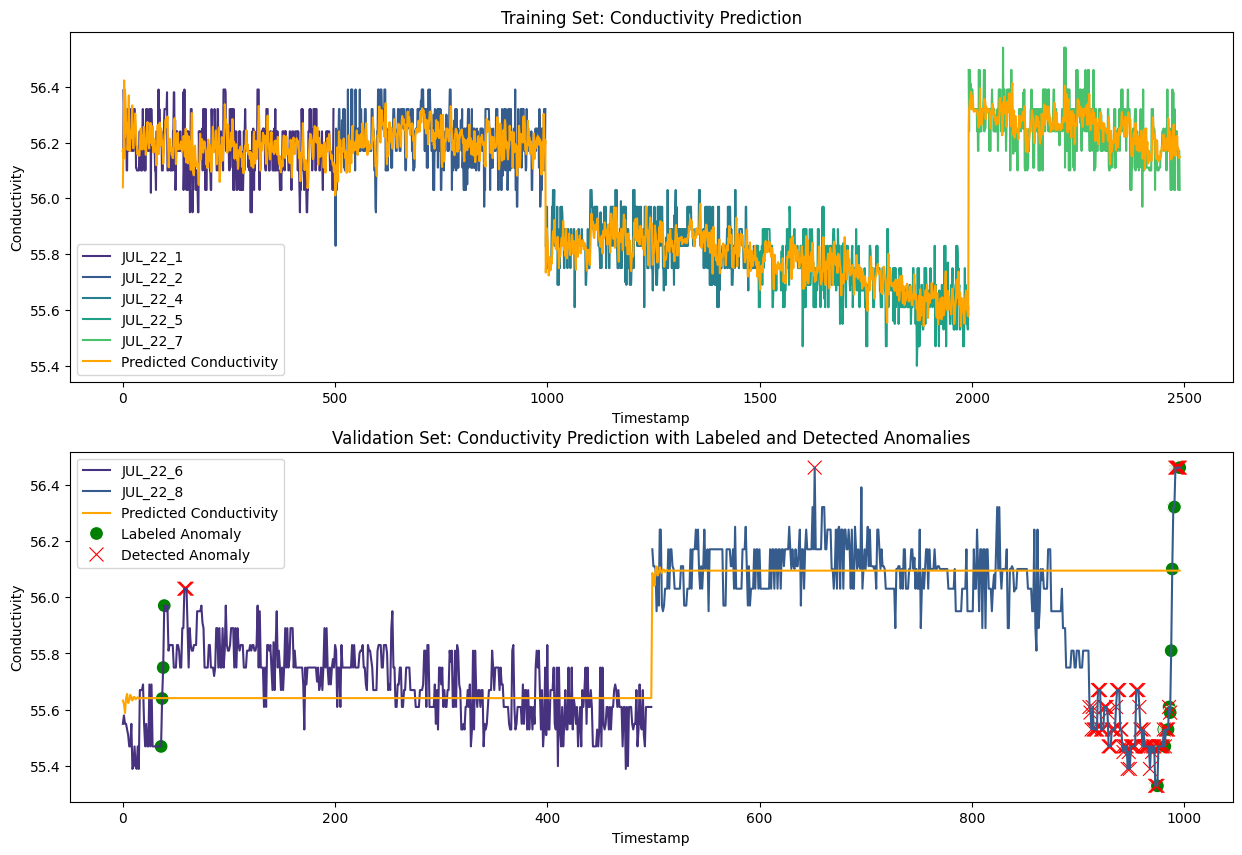

Matched Anomalies between Labeled and Detected:
    index  conductivity
0     973         55.33
1     974         55.33
2     975         55.33
3     976         55.47
4     977         55.47
5     978         55.47
6     979         55.47
7     980         55.47
8     981         55.53
9     982         55.47
10    983         55.53
11    984         55.53
12    985         55.53
13    986         55.61
14    987         55.59
15    992         56.46
16    993         56.46
17    994         56.46
18    995         56.46
19    996         56.46


In [15]:
# -----------------------------------------------
# 5. Data Visualization
# -----------------------------------------------

# Plot the results
fig, ax = plt.subplots(2, 1, figsize=(15, 10))
ax1 = sns.lineplot(data=train_conduct, x='index', y='conductivity', hue='run_id', palette=sns.color_palette("viridis"), ax=ax[0])
ax1 = sns.lineplot(data=train_conduct, x='index', y='Predicted_conductivity', color='orange', label='Predicted Conductivity', ax=ax[0])
ax1.set_title('Training Set: Conductivity Prediction')
ax1.set_xlabel('Timestamp')
ax1.set_ylabel('Conductivity')
ax1.legend()

ax2 = sns.lineplot(data=valid_conduct, x='index', y='conductivity', hue='run_id', palette=sns.color_palette("viridis"), ax=ax[1])
ax2 = sns.lineplot(data=valid_conduct, x='index', y='Predicted_conductivity', color='orange', label='Predicted Conductivity', ax=ax[1])
anomalies_labeled = valid_conduct[valid_conduct['anomaly_label'] == 1]
anomalies_labeled['anomaly_label'] = ['Labeled Anomaly']*len(anomalies_labeled)
print("Labeled Anomalies:")
print(anomalies_labeled[['index', 'conductivity']])
ax2 = sns.scatterplot(data=anomalies_labeled, x='index', y='conductivity', color='green', style='anomaly_label', markers='o', s=100, legend='full', ax=ax[1])
anomalies_detected = valid_conduct[valid_conduct['Predicted_Anomaly'] == 1]
anomalies_detected['Predicted_Anomaly'] = ['Detected Anomaly']*len(anomalies_detected)
print("Detected Anomalies:")
print(anomalies_detected[['index', 'conductivity']])
ax2 = sns.scatterplot(data=anomalies_detected, x='index', y='conductivity', color='red', style='Predicted_Anomaly',  markers='x', s=100, legend='full', ax=ax[1])

ax2.set_title('Validation Set: Conductivity Prediction with Labeled and Detected Anomalies')
ax2.set_xlabel('Timestamp')
ax2.set_ylabel('Conductivity')
ax2.legend()

plt.show()

match_anomalies = pd.merge(anomalies_labeled, anomalies_detected, how='inner', on=['index', 'conductivity'])
print("Matched Anomalies between Labeled and Detected:")
print(match_anomalies[['index', 'conductivity']])


--- ANOMALY DETECTION EVALUATION (Out-of-Sample Runs) ---
Optimal Anomaly Threshold (Score): 0.3441
--------------------------------------------------
Precision: 0.2326 (Correct Detections / All Detections)
Recall:    0.7143 (Detections / All True Anomalies)
F1-Score:  0.3509 (Best Balance of P/R)
ROC AUC:   0.8627 (Model's overall ranking ability)
--------------------------------------------------
The model is evaluated on its ability to generalize to new runs.


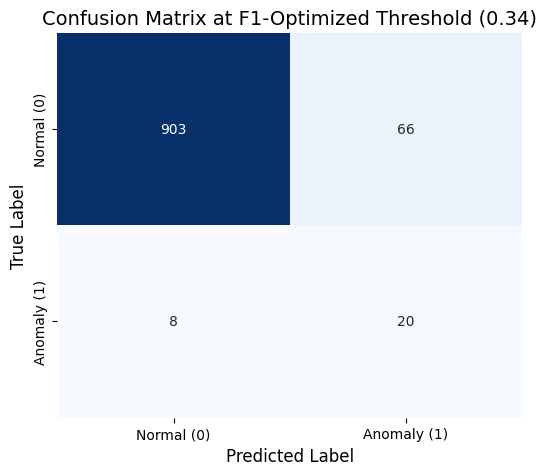

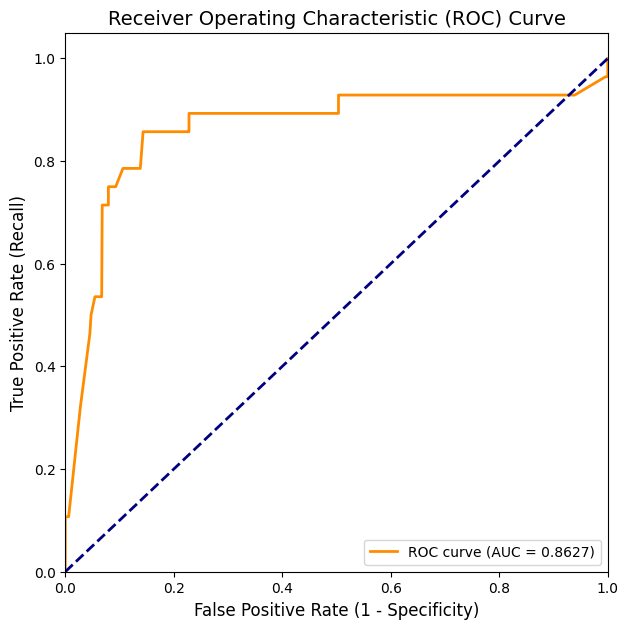

In [16]:
# ----------------------------------------------------
# 6. FORMAL EVALUATION
# ----------------------------------------------------

# VISUALIZATION FUNCTIONS

def plot_confusion_matrix(y_true, y_pred, title='Confusion Matrix'):
    """Plots a heatmap of the Confusion Matrix."""
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(6, 5))
    sns.heatmap(
        cm, 
        annot=True, 
        fmt='d', 
        cmap='Blues', 
        cbar=False,
        xticklabels=['Normal (0)', 'Anomaly (1)'],
        yticklabels=['Normal (0)', 'Anomaly (1)']
    )
    plt.title(title, fontsize=14)
    plt.ylabel('True Label', fontsize=12)
    plt.xlabel('Predicted Label', fontsize=12)
    plt.show()


def plot_roc_curve(y_true, y_scores, roc_auc):
    """Plots the Receiver Operating Characteristic (ROC) curve."""
    # Ensure y_scores are in the correct format (higher score = more positive class, 1)
    fpr, tpr, thresholds = roc_curve(y_true, y_scores)
    
    plt.figure(figsize=(7, 7))
    plt.plot(
        fpr, tpr, 
        color='darkorange', 
        lw=2, 
        label=f'ROC curve (AUC = {roc_auc:.4f})'
    )
    # Baseline random classifier line
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate (1 - Specificity)', fontsize=12)
    plt.ylabel('True Positive Rate (Recall)', fontsize=12)
    plt.title('Receiver Operating Characteristic (ROC) Curve', fontsize=14)
    plt.legend(loc="lower right")
    plt.show()
    
    
pred_labels = valid_conduct['Predicted_Anomaly']

# --- A. Metric Calculation (Same as before) ---
precision = precision_score(true_labels, pred_labels, zero_division=0)
recall = recall_score(true_labels, pred_labels, zero_division=0)
roc_auc = roc_auc_score(true_labels, scores)

print("\n--- ANOMALY DETECTION EVALUATION (Out-of-Sample Runs) ---")
print(f"Optimal Anomaly Threshold (Score): {best_threshold:.4f}")
print("-" * 50)
print(f"Precision: {precision:.4f} (Correct Detections / All Detections)")
print(f"Recall:    {recall:.4f} (Detections / All True Anomalies)")
print(f"F1-Score:  {best_f1:.4f} (Best Balance of P/R)")
print(f"ROC AUC:   {roc_auc:.4f} (Model's overall ranking ability)")
print("-" * 50)
print("The model is evaluated on its ability to generalize to new runs.")

# --- B. Visualization Calls ---

# 1. Confusion Matrix
plot_confusion_matrix(
    y_true=true_labels, 
    y_pred=pred_labels, 
    title=f'Confusion Matrix at F1-Optimized Threshold ({best_threshold:.2f})'
)

# 2. ROC AUC Curve
plot_roc_curve(
    y_true=true_labels, 
    y_scores=scores, 
    roc_auc=roc_auc
)


Calculating run-specific baseline offsets for testation runs...
Labeled Anomalies:
     index  conductivity
354    354         56.60
355    355         56.66
356    356         56.74
357    357         56.69
358    358         56.66
..     ...           ...
488    488         57.01
489    489         57.01
491    491         57.01
494    494         57.01
497    497         57.01

[78 rows x 2 columns]
Detected Anomalies:
Empty DataFrame
Columns: [index, conductivity]
Index: []


c:\Users\kittyoomm\Desktop\Work@MTEC\PlateMon_data_analytics\.venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
c:\Users\kittyoomm\Desktop\Work@MTEC\PlateMon_data_analytics\.venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
C:\Users\kittyoomm\AppData\Local\Temp\ipykernel_9780\2288640686.py:70: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  anomalies_labeled['anomaly_label'] = ['Labeled Ano

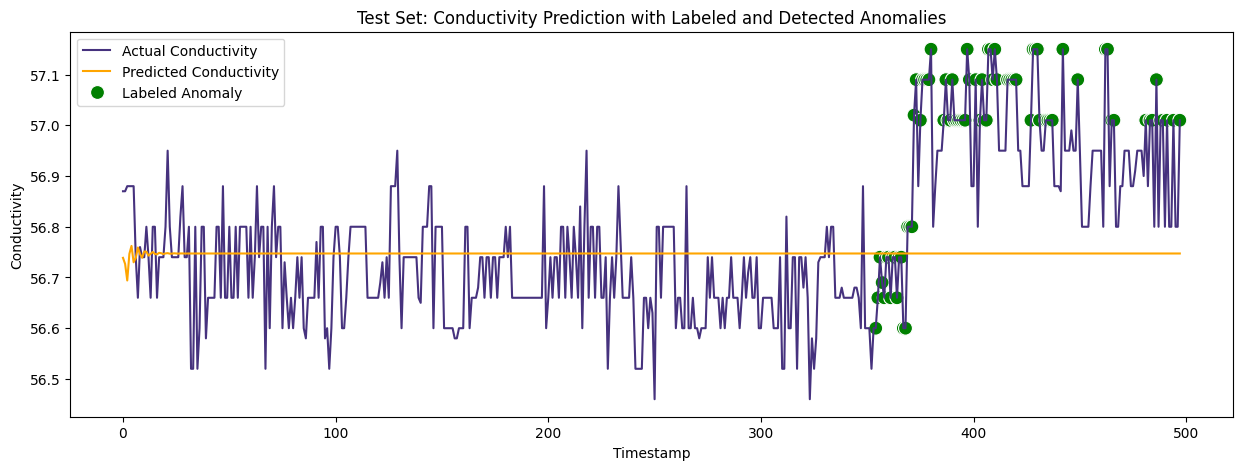

Matched Anomalies between Labeled and Detected:
Empty DataFrame
Columns: [index, conductivity]
Index: []

--- ANOMALY DETECTION EVALUATION (Out-of-Sample Runs) ---
Optimal Anomaly Threshold (Score): 0.4027
--------------------------------------------------
Precision: 0.0000 (Correct Detections / All Detections)
Recall:    0.0000 (Detections / All True Anomalies)
F1-Score:  0.0000 (Best Balance of P/R)
ROC AUC:   0.8466 (Model's overall ranking ability)
--------------------------------------------------
The model is evaluated on its ability to generalize to new runs.


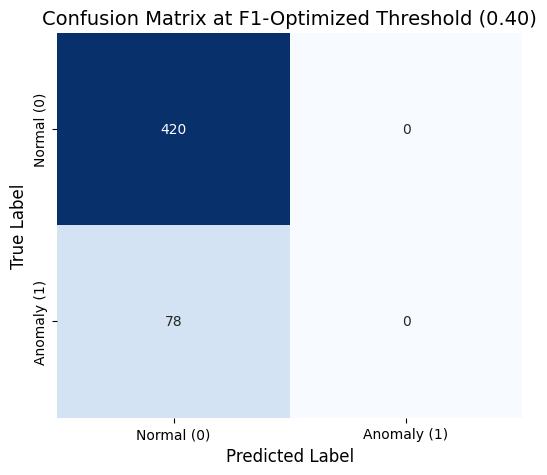

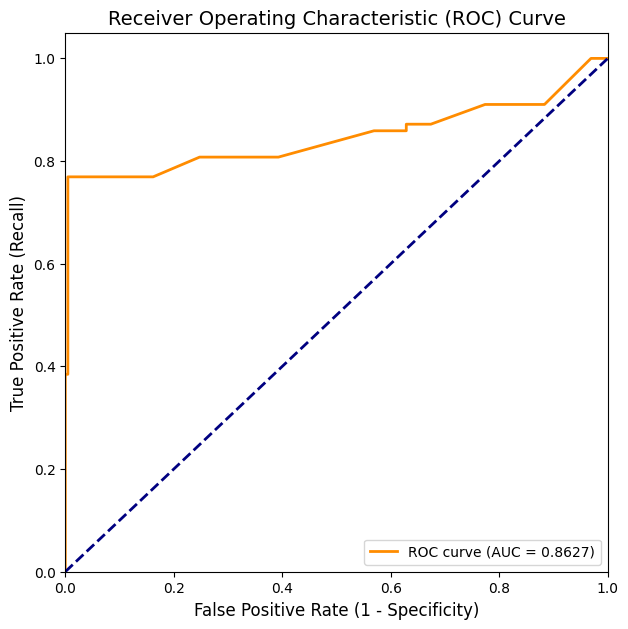

In [17]:
# ----------------------------------------------------
# 7. TEST SET EVALUATION
# ----------------------------------------------------

# --- Prepare testation Data for Iteration ---
test_conduct['Residual'] = np.nan # Placeholder for the final residual
test_conduct['Predicted_conductivity'] = np.nan # Placeholder for the final adjusted prediction

print("\nCalculating run-specific baseline offsets for testation runs...")

# Iterate through each unseen Run_ID in the testation set
for run_id, run_data in test_conduct.groupby('run_id'):
    
    # 1. Setup indices and data for the current run
    run_len = len(run_data)
    
    # Indices for prediction (start immediately after training ends)
    test_start_idx = len(y_train) 
    test_end_idx = test_start_idx + run_len - 1
    
    # Isolate the exogenous data for this specific run
    X_run = X_test.iloc[run_data.index, :] 

    # 2. Generate RAW Prediction (using the common intercept)
    raw_run_forecast = Hier_results.get_prediction(
        start=test_start_idx, 
        end=test_end_idx, 
        exog=X_run
    ).predicted_mean
    raw_run_forecast = data_scaler.inverse_transform(raw_run_forecast.values.reshape(-1, 1)).flatten()
    
    # 3. Determine the Initial Offset (Baseline Correction)
    
    # Get the actual and raw predicted values for the lookback window
    window_end = min(WINDOW_SIZE, run_len)
    actuals_window = run_data['conductivity'].iloc[:window_end]
    predictions_window = raw_run_forecast[:window_end]
    
    # Calculate the average difference (error) in the initial window
    initial_offset = (actuals_window - predictions_window).mean()
    
    # 4. Apply the Offset and Calculate Residuals
    
    # Apply the offset to the entire run's raw prediction
    adjusted_prediction = raw_run_forecast + initial_offset
    
    # Calculate the residual using the actual value and the adjusted prediction
    residual = run_data['conductivity'] - adjusted_prediction
    
    # 5. Store Results back into the main DataFrame
    test_conduct.loc[run_data.index, 'Predicted_conductivity'] = adjusted_prediction
    test_conduct.loc[run_data.index, 'Residual'] = residual

# Final Anomaly Score is the absolute residual
test_conduct['Anomaly_Score'] = np.abs(test_conduct['Residual'])

test_true_labels = test_conduct['anomaly_label'].astype(int)
test_scores = test_conduct['Anomaly_Score']

# Apply the best threshold
test_threshold = np.percentile(test_scores, q)
test_conduct['Predicted_Anomaly'] = (test_conduct['Anomaly_Score'] > test_threshold).astype(int)
test_conduct

fig, ax = plt.subplots(figsize=(15, 5))

ax2 = sns.lineplot(data=test_conduct, x='index', y='conductivity', color=sns.color_palette("viridis")[0], label='Actual Conductivity')
ax2 = sns.lineplot(data=test_conduct, x='index', y='Predicted_conductivity', color='orange', label='Predicted Conductivity')
anomalies_labeled = test_conduct[test_conduct['anomaly_label'] == 1]
anomalies_labeled['anomaly_label'] = ['Labeled Anomaly']*len(anomalies_labeled)
print("Labeled Anomalies:")
print(anomalies_labeled[['index', 'conductivity']])
ax2 = sns.scatterplot(data=anomalies_labeled, x='index', y='conductivity', color='green', style='anomaly_label', markers='o', s=100, legend='full')
anomalies_detected = test_conduct[test_conduct['Predicted_Anomaly'] == 1]
anomalies_detected['Predicted_Anomaly'] = ['Detected Anomaly']*len(anomalies_detected)
print("Detected Anomalies:")
print(anomalies_detected[['index', 'conductivity']])
ax2 = sns.scatterplot(data=anomalies_detected, x='index', y='conductivity', color='red', style='Predicted_Anomaly',  markers='x', s=100, legend='full')

ax2.set_title('Test Set: Conductivity Prediction with Labeled and Detected Anomalies')
ax2.set_xlabel('Timestamp')
ax2.set_ylabel('Conductivity')
ax2.legend()

plt.show()

match_anomalies = pd.merge(anomalies_labeled, anomalies_detected, how='inner', on=['index', 'conductivity'])
print("Matched Anomalies between Labeled and Detected:")
print(match_anomalies[['index', 'conductivity']])

test_pred_labels = test_conduct['Predicted_Anomaly']

# --- A. Metric Calculation (Same as before) ---
test_precision = precision_score(test_true_labels, test_pred_labels, zero_division=0)
test_recall = recall_score(test_true_labels, test_pred_labels, zero_division=0)
test_f1_score = f1_score(test_true_labels, test_pred_labels, zero_division=0)
test_roc_auc = roc_auc_score(test_true_labels, test_scores)

print("\n--- ANOMALY DETECTION EVALUATION (Out-of-Sample Runs) ---")
print(f"Optimal Anomaly Threshold (Score): {test_threshold:.4f}")
print("-" * 50)
print(f"Precision: {test_precision:.4f} (Correct Detections / All Detections)")
print(f"Recall:    {test_recall:.4f} (Detections / All True Anomalies)")
print(f"F1-Score:  {test_f1_score:.4f} (Best Balance of P/R)")
print(f"ROC AUC:   {test_roc_auc:.4f} (Model's overall ranking ability)")
print("-" * 50)
print("The model is evaluated on its ability to generalize to new runs.")

# --- B. Visualization Calls ---

# 1. Confusion Matrix
plot_confusion_matrix(
    y_true=test_true_labels, 
    y_pred=test_pred_labels, 
    title=f'Confusion Matrix at F1-Optimized Threshold ({test_threshold:.2f})'
)

# 2. ROC AUC Curve
plot_roc_curve(
    y_true=test_true_labels, 
    y_scores=test_scores, 
    roc_auc=roc_auc
)

In [18]:
test_conduct

,index,conductivity,run_id,anomaly_label,timestamp,stand_value,Residual,Predicted_conductivity,Anomaly_Score,Predicted_Anomaly
0,0,56.87,JUL_24_3,0,2025-07-24 10:23:37,3.427714,0.131286,56.738714,0.131286,0
1,1,56.87,JUL_24_3,0,2025-07-24 10:23:39,3.427714,0.143309,56.726691,0.143309,0
2,2,56.88,JUL_24_3,0,2025-07-24 10:23:41,3.468988,0.185894,56.694106,0.185894,0
3,3,56.88,JUL_24_3,0,2025-07-24 10:23:43,3.468988,0.133494,56.746506,0.133494,0
4,4,56.88,JUL_24_3,0,2025-07-24 10:23:45,3.468988,0.117744,56.762256,0.117744,0
...,...,...,...,...,...,...,...,...,...,...
493,493,56.80,JUL_24_3,0,2025-07-24 10:40:06,3.138797,0.052701,56.747299,0.052701,0
494,494,57.01,JUL_24_3,1,2025-07-24 10:40:08,4.005547,0.262701,56.747299,0.262701,0
495,495,56.80,JUL_24_3,0,2025-07-24 10:40:10,3.138797,0.052701,56.747299,0.052701,0
496,496,56.80,JUL_24_3,0,2025-07-24 10:40:12,3.138797,0.052701,56.747299,0.052701,0


### Hierachical training method

In [19]:
# -----------------------------------------------
# 1. LOAD AND PREPARE YOUR DATASET
# -----------------------------------------------

# Path to data folder
data_path = Path.cwd()/'Datasets'

# Path from data folder to the data file
train_c_filename = 'train_c_data.xlsx'
valid_c_filename = 'valid_c_data.xlsx'

# import data file
train_c = pd.read_excel(data_path/train_c_filename)
valid_c = pd.read_excel(data_path/valid_c_filename)

# Extract consuctivity data
train_conduct = train_c[['index', 'conductivity', 'run_id', 'timestamp']].copy()
valid_conduct = valid_c[['index', 'conductivity', 'run_id', 'anomaly_label', 'timestamp']].copy()

In [20]:
# Function to standardize data
def parse_and_standardize(df: pd.DataFrame, scaler: StandardScaler = None, parameter: str = train_conduct.columns[1]) -> StandardScaler:
    #df['timestamp'] = pd.to_datetime(df['timestamp'])
    df['stand_value'] = df[parameter]
    if not scaler:
        scaler = StandardScaler()
        scaler.fit(df['stand_value'].values.reshape(-1, 1))
    df['stand_value'] = scaler.transform(df['stand_value'].values.reshape(-1, 1))
    return scaler

In [21]:
data_scaler = parse_and_standardize(df=train_conduct, parameter='conductivity')
parse_and_standardize(df=valid_conduct, scaler=data_scaler, parameter='conductivity')

,copy,True
,with_mean,True
,with_std,True


In [22]:
# --- MAPPING AND CLEANING FUNCTION ---
def preprocess_data(df, fe_cols_to_keep=None):
    # Rename columns to standard names
    df = df.rename(columns={
        'timestamp': 'Date',
        'run_id': 'Run_ID',
        'stand_value': 'Conductivity_Standardized',
    })
    df['Date'] = pd.to_datetime(df['Date'])
    df = df.set_index('Date')
    df.sort_values(by=['Run_ID', 'Date'], inplace=True)

    # Create ALL possible Fixed Effect (FE) Dummies, including the column for the first run
    run_dummies = pd.get_dummies(df['Run_ID'], prefix='Run_FE', dtype=int)
    
    # If this is the validation step, we need to ensure it has all FE columns
    if fe_cols_to_keep is not None:
        # Reindex to match the columns trained by the model
        df_fe = run_dummies.reindex(columns=fe_cols_to_keep, fill_value=0)
    else:
        # For training, determine the FE columns and drop the first one as the baseline
        # We need to explicitly exclude one to serve as the baseline intercept (Constant)
        fe_cols = run_dummies.columns
        df_fe = run_dummies.drop(columns=[fe_cols[0]]) # Drop the first FE column as baseline
        
    df_processed = pd.concat([df, df_fe], axis=1)

    # Separate endog (y) and exog (X)
    endog = df_processed['Conductivity_Standardized']
    exog = df_fe # This is the FE matrix we need for SARIMAX
    
    return endog, exog, df_processed

In [23]:
# --- Preprocess Training Data ---
y_train, X_train, df_train = preprocess_data(train_conduct, fe_cols_to_keep=None)

# Store the final list of FE columns used in training (excluding the baseline FE)
trained_fe_cols = X_train.columns

# Preprocess the validation set, ensuring its FE matrix matches the training model
y_valid, X_valid, df_valid_processed = preprocess_data(valid_conduct, fe_cols_to_keep=trained_fe_cols)

In [24]:
# -----------------------------------------------
# 2. FIT THE HIERARCHICAL TIME SERIES MODEL
# -----------------------------------------------

# Define the ARIMA/SARIMA order parameters:
# (p, d, q) for ARIMA terms, (P, D, Q, s) for Seasonal terms
import pmdarima as pm

# The auto_arima function handles the grid search and AIC minimization automatically
model_auto = pm.auto_arima(
    y=y_train,              # The training parameter values
    exogenous=X_train,      # The Fixed Effect Dummies
    start_p=1, max_p=3,     # Range for non-seasonal AR
    start_q=1, max_q=3,     # Range for non-seasonal MA
    d=None, D=None,         # Let the function decide the differencing (d)
    seasonal=False, # Set seasonal=True and define your seasonal period 's_val'
    trace=True,             # Print results for each iteration
    error_action='ignore',
    suppress_warnings=True,
    stepwise=True           # Speeds up the search
)

# The optimal orders are then stored in model_auto.order and model_auto.seasonal_order
order_params = model_auto.order
seasonal_params = model_auto.seasonal_order # No seasonal components

print(f"Fitting SARIMAX model with order={order_params}, seasonal_order={seasonal_params} and Fixed Effects...")

try:
    sarimax_model = sm.tsa.statespace.SARIMAX(
        endog=y_train,
        exog=X_train,
        order=order_params,
        seasonal_order=seasonal_params,
        enforce_stationarity=False,
        enforce_invertibility=False 
    )

    sarimax_results = sarimax_model.fit(disp=False)
    print("\n--- SARIMAX Model Fitting Complete ---")
    
except Exception as e:
    print(f"SARIMAX Model fitting failed: {e}")
    exit()

c:\Users\kittyoomm\Desktop\Work@MTEC\PlateMon_data_analytics\.venv\Lib\site-packages\sklearn\utils\deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\kittyoomm\Desktop\Work@MTEC\PlateMon_data_analytics\.venv\Lib\site-packages\sklearn\utils\deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\kittyoomm\Desktop\Work@MTEC\PlateMon_data_analytics\.venv\Lib\site-packages\sklearn\utils\deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\kittyoomm\Desktop\Work@MTEC\PlateMon_data_analytics\.venv\Lib\site-packages\sklearn\utils\deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\kittyoomm\Desktop\Work@MTEC\Pla

Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=2275.177, Time=0.49 sec


c:\Users\kittyoomm\Desktop\Work@MTEC\PlateMon_data_analytics\.venv\Lib\site-packages\sklearn\utils\deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=3116.447, Time=0.28 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=2546.977, Time=0.21 sec


c:\Users\kittyoomm\Desktop\Work@MTEC\PlateMon_data_analytics\.venv\Lib\site-packages\sklearn\utils\deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\kittyoomm\Desktop\Work@MTEC\PlateMon_data_analytics\.venv\Lib\site-packages\sklearn\utils\deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=2279.162, Time=0.31 sec


c:\Users\kittyoomm\Desktop\Work@MTEC\PlateMon_data_analytics\.venv\Lib\site-packages\sklearn\utils\deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(0,1,0)(0,0,0)[0]             : AIC=3114.448, Time=0.28 sec


c:\Users\kittyoomm\Desktop\Work@MTEC\PlateMon_data_analytics\.venv\Lib\site-packages\sklearn\utils\deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=2172.289, Time=0.52 sec


c:\Users\kittyoomm\Desktop\Work@MTEC\PlateMon_data_analytics\.venv\Lib\site-packages\sklearn\utils\deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=2220.083, Time=0.23 sec


c:\Users\kittyoomm\Desktop\Work@MTEC\PlateMon_data_analytics\.venv\Lib\site-packages\sklearn\utils\deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=2174.204, Time=1.68 sec


c:\Users\kittyoomm\Desktop\Work@MTEC\PlateMon_data_analytics\.venv\Lib\site-packages\sklearn\utils\deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=2174.057, Time=1.39 sec


c:\Users\kittyoomm\Desktop\Work@MTEC\PlateMon_data_analytics\.venv\Lib\site-packages\sklearn\utils\deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=2227.230, Time=0.86 sec


c:\Users\kittyoomm\Desktop\Work@MTEC\PlateMon_data_analytics\.venv\Lib\site-packages\sklearn\utils\deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=2187.450, Time=0.46 sec


c:\Users\kittyoomm\Desktop\Work@MTEC\PlateMon_data_analytics\.venv\Lib\site-packages\sklearn\utils\deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=2024.134, Time=2.51 sec


c:\Users\kittyoomm\Desktop\Work@MTEC\PlateMon_data_analytics\.venv\Lib\site-packages\sklearn\utils\deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(3,1,3)(0,0,0)[0] intercept   : AIC=1977.931, Time=3.71 sec


c:\Users\kittyoomm\Desktop\Work@MTEC\PlateMon_data_analytics\.venv\Lib\site-packages\sklearn\utils\deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(2,1,3)(0,0,0)[0] intercept   : AIC=2161.543, Time=1.87 sec


c:\Users\kittyoomm\Desktop\Work@MTEC\PlateMon_data_analytics\.venv\Lib\site-packages\sklearn\utils\deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(3,1,3)(0,0,0)[0]             : AIC=1971.422, Time=1.15 sec


c:\Users\kittyoomm\Desktop\Work@MTEC\PlateMon_data_analytics\.venv\Lib\site-packages\sklearn\utils\deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(2,1,3)(0,0,0)[0]             : AIC=2159.547, Time=0.58 sec


c:\Users\kittyoomm\Desktop\Work@MTEC\PlateMon_data_analytics\.venv\Lib\site-packages\sklearn\utils\deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(3,1,2)(0,0,0)[0]             : AIC=2022.144, Time=0.58 sec


c:\Users\kittyoomm\Desktop\Work@MTEC\PlateMon_data_analytics\.venv\Lib\site-packages\sklearn\utils\deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(2,1,2)(0,0,0)[0]             : AIC=2172.058, Time=0.34 sec

Best model:  ARIMA(3,1,3)(0,0,0)[0]          
Total fit time: 17.458 seconds
Fitting SARIMAX model with order=(3, 1, 3), seasonal_order=(0, 0, 0, 0) and Fixed Effects...


c:\Users\kittyoomm\Desktop\Work@MTEC\PlateMon_data_analytics\.venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\kittyoomm\Desktop\Work@MTEC\PlateMon_data_analytics\.venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)



--- SARIMAX Model Fitting Complete ---


c:\Users\kittyoomm\Desktop\Work@MTEC\PlateMon_data_analytics\.venv\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


In [25]:
# Store the prediction of the training set
train_conduct['Prediction'] = sarimax_results.fittedvalues.reset_index(drop=True)
train_conduct['Predicted_conductivity'] = data_scaler.inverse_transform(train_conduct['Prediction'].values.reshape(-1, 1)) 
train_conduct

,index,conductivity,run_id,timestamp,stand_value,Prediction,Predicted_conductivity
0,0,56.17,JUL_22_1,2025-07-22 13:21:01,0.538548,0.000000,56.039518
1,1,56.17,JUL_22_1,2025-07-22 13:21:03,0.538548,0.570969,56.177855
2,2,56.39,JUL_22_1,2025-07-22 13:21:05,1.446572,0.425012,56.142492
3,3,56.32,JUL_22_1,2025-07-22 13:21:07,1.157655,1.581385,56.422663
4,4,56.39,JUL_22_1,2025-07-22 13:21:09,1.446572,0.737238,56.218139
...,...,...,...,...,...,...,...
2485,2485,56.17,JUL_22_7,2025-07-22 16:34:50,0.538548,0.568822,56.177335
2486,2486,56.03,JUL_22_7,2025-07-22 16:34:52,-0.039285,0.573266,56.178412
2487,2487,56.17,JUL_22_7,2025-07-22 16:34:54,0.538548,0.451106,56.148814
2488,2488,56.17,JUL_22_7,2025-07-22 16:34:56,0.538548,0.430966,56.143935


In [26]:
# ----------------------------------------------------
# 3. CALCULATE AND APPLY RUN-SPECIFIC OFFSETS
# ----------------------------------------------------

# --- Define the Lookback Window ---
# This is the number of initial data points used to estimate the new run's baseline
WINDOW_SIZE = 60

# --- Prepare Validation Data for Iteration ---
valid_conduct['Residual'] = np.nan # Placeholder for the final residual
valid_conduct['Predicted_conductivity'] = np.nan # Placeholder for the final adjusted prediction

print("\nCalculating run-specific baseline offsets for validation runs...")

# Iterate through each unseen Run_ID in the validation set
for run_id, run_data in valid_conduct.groupby('run_id'):
    
    # 1. Setup indices and data for the current run
    run_len = len(run_data)
    
    # Indices for prediction (start immediately after training ends)
    start_idx = len(y_train) 
    end_idx = start_idx + run_len - 1
    
    # Isolate the exogenous data for this specific run
    X_run = X_valid.iloc[run_data.index, :] 

    # 2. Generate RAW Prediction (using the common intercept)
    raw_run_forecast = sarimax_results.get_prediction(
        start=start_idx, 
        end=end_idx, 
        exog=X_run
    ).predicted_mean
    raw_run_forecast = data_scaler.inverse_transform(raw_run_forecast.values.reshape(-1, 1)).flatten()
    
    # 3. Determine the Initial Offset (Baseline Correction)
    
    # Get the actual and raw predicted values for the lookback window
    window_end = min(WINDOW_SIZE, run_len)
    actuals_window = run_data['conductivity'].iloc[:window_end]
    predictions_window = raw_run_forecast[:window_end]
    
    # Calculate the average difference (error) in the initial window
    initial_offset = (actuals_window - predictions_window).mean()
    
    # 4. Apply the Offset and Calculate Residuals
    
    # Apply the offset to the entire run's raw prediction
    adjusted_prediction = raw_run_forecast + initial_offset
    
    # Calculate the residual using the actual value and the adjusted prediction
    residual = run_data['conductivity'] - adjusted_prediction
    
    # 5. Store Results back into the main DataFrame
    valid_conduct.loc[run_data.index, 'Predicted_conductivity'] = adjusted_prediction
    valid_conduct.loc[run_data.index, 'Residual'] = residual

# Final Anomaly Score is the absolute residual
valid_conduct['Anomaly_Score'] = np.abs(valid_conduct['Residual'])


Calculating run-specific baseline offsets for validation runs...


c:\Users\kittyoomm\Desktop\Work@MTEC\PlateMon_data_analytics\.venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
c:\Users\kittyoomm\Desktop\Work@MTEC\PlateMon_data_analytics\.venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
c:\Users\kittyoomm\Desktop\Work@MTEC\PlateMon_data_analytics\.venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
c:\Users\kittyoomm\Desktop\Work@MTEC\PlateMon_data_analytics\.venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: FutureWa

In [27]:
# ----------------------------------------------------
# 4. ANOMALY DETECTION & THRESHOLD TUNING (on valid_conduct)
# ----------------------------------------------------
#start_idx = len(df_train)
#end_idx = start_idx + len(df_valid_processed) - 1

# Calculate Residuals and Anomaly Score
#print("Predicting residuals on unseen validation 'Run_ID's...")
#valid_forecast = sarimax_results.get_prediction(
#    start=start_idx, 
#    end=end_idx, 
#    exog=X_valid
#)

# Store prediction for validation ser
#valid_conduct['Prediction'] = valid_forecast.predicted_mean.reset_index(drop=True)
#valid_conduct['Predicted_conductivity'] = data_scaler.inverse_transform(valid_conduct['Prediction'].values.reshape(-1, 1))

# Calculate Residual (Actual - Predicted)
#valid_conduct['Residual'] = valid_conduct['Predicted_conductivity'] - valid_conduct['conductivity']
#valid_conduct['Anomaly_Score'] = np.abs(valid_conduct['Residual'])

# Dynamic Threshold Determination (Tuning on Labeled Validation Data)
true_labels = valid_conduct['anomaly_label'].astype(int)
scores = valid_conduct['Anomaly_Score']

best_f1 = -1
best_threshold = 0
for q in np.arange(90, 100.1, 0.1):
    current_threshold = np.percentile(scores, q)
    predicted_labels = (scores > current_threshold).astype(int)
    
    current_f1 = f1_score(true_labels, predicted_labels, zero_division=0)
    
    if current_f1 > best_f1:
        best_f1 = current_f1
        best_threshold = current_threshold

# Apply the best threshold
valid_conduct['Predicted_Anomaly'] = (valid_conduct['Anomaly_Score'] > best_threshold).astype(int)
valid_conduct

,index,conductivity,run_id,anomaly_label,timestamp,stand_value,Residual,Predicted_conductivity,Anomaly_Score,Predicted_Anomaly
0,0,55.55,JUL_22_6,0,2025-07-22 15:45:16,-2.020427,-0.082880,55.632880,0.082880,0
1,1,55.58,JUL_22_6,0,2025-07-22 15:45:18,-1.896605,-0.040858,55.620858,0.040858,0
2,2,55.55,JUL_22_6,0,2025-07-22 15:45:20,-2.020427,-0.038272,55.588272,0.038272,0
3,3,55.55,JUL_22_6,0,2025-07-22 15:45:22,-2.020427,-0.090672,55.640672,0.090672,0
4,4,55.53,JUL_22_6,0,2025-07-22 15:45:24,-2.102974,-0.126422,55.656422,0.126422,0
...,...,...,...,...,...,...,...,...,...,...
992,992,56.46,JUL_22_8,1,2025-07-22 16:58:42,1.735488,0.365868,56.094132,0.365868,1
993,993,56.46,JUL_22_8,1,2025-07-22 16:58:44,1.735488,0.365868,56.094132,0.365868,1
994,994,56.46,JUL_22_8,1,2025-07-22 16:58:46,1.735488,0.365868,56.094132,0.365868,1
995,995,56.46,JUL_22_8,1,2025-07-22 16:58:48,1.735488,0.365868,56.094132,0.365868,1


C:\Users\kittyoomm\AppData\Local\Temp\ipykernel_9780\3177699055.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  anomalies_labeled['anomaly_label'] = ['Labeled Anomaly']*len(anomalies_labeled)
C:\Users\kittyoomm\AppData\Local\Temp\ipykernel_9780\3177699055.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  anomalies_detected['Predicted_Anomaly'] = ['Detected Anomaly']*len(anomalies_detected)


Labeled Anomalies:
     index  conductivity
36      36         55.47
37      37         55.64
38      38         55.75
39      39         55.97
973    973         55.33
974    974         55.33
975    975         55.33
976    976         55.47
977    977         55.47
978    978         55.47
979    979         55.47
980    980         55.47
981    981         55.53
982    982         55.47
983    983         55.53
984    984         55.53
985    985         55.53
986    986         55.61
987    987         55.59
988    988         55.81
989    989         56.10
990    990         56.32
991    991         56.32
992    992         56.46
993    993         56.46
994    994         56.46
995    995         56.46
996    996         56.46
Detected Anomalies:
     index  conductivity
58      58         56.03
59      59         56.03
60      60         56.03
652    652         56.46
911    911         55.61
..     ...           ...
992    992         56.46
993    993         56.46
994    994 

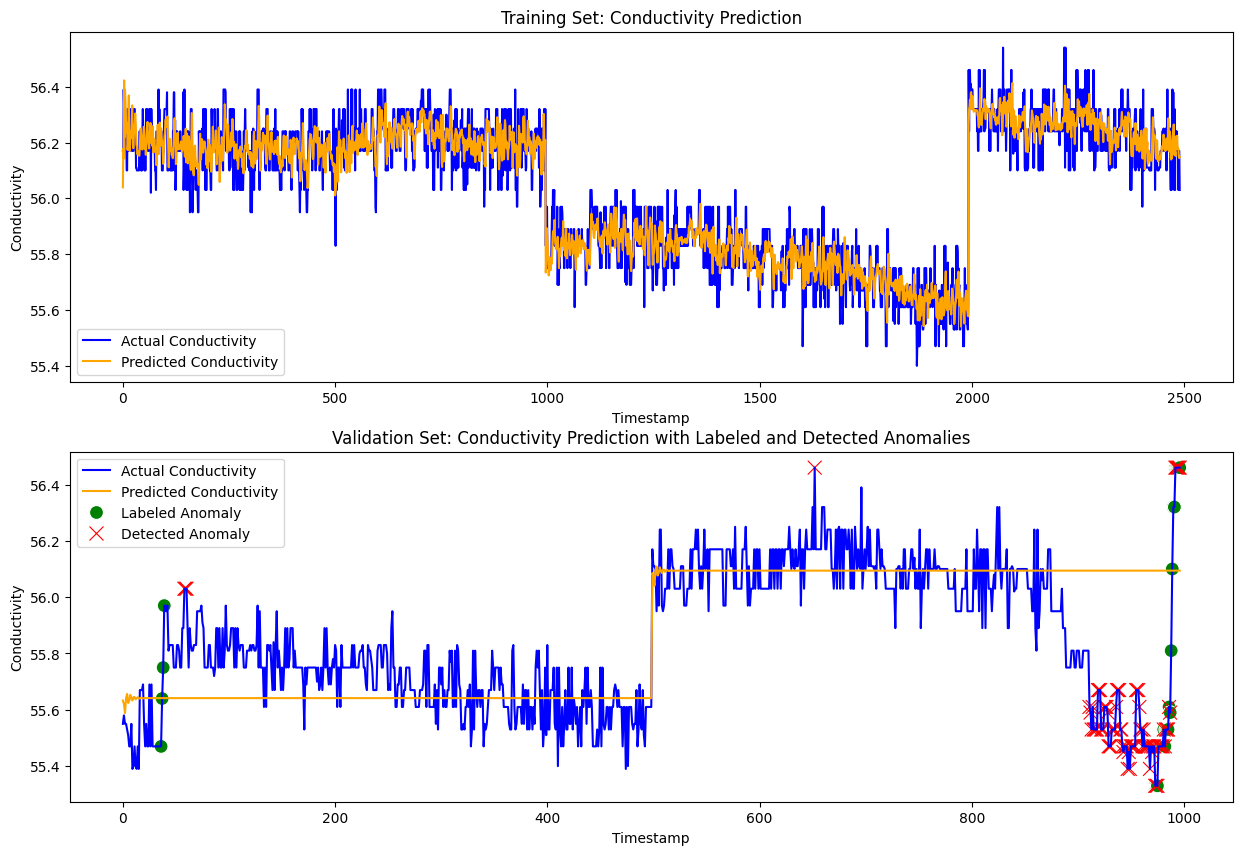

Matched Anomalies between Labeled and Detected:
    index  conductivity
0     973         55.33
1     974         55.33
2     975         55.33
3     976         55.47
4     977         55.47
5     978         55.47
6     979         55.47
7     980         55.47
8     981         55.53
9     982         55.47
10    983         55.53
11    984         55.53
12    985         55.53
13    986         55.61
14    987         55.59
15    992         56.46
16    993         56.46
17    994         56.46
18    995         56.46
19    996         56.46


In [28]:
# -----------------------------------------------
# 5. Data Visualization
# -----------------------------------------------

# Plot the results
fig, ax = plt.subplots(2, 1, figsize=(15, 10))
ax1 = sns.lineplot(data=train_conduct, x='index', y='conductivity', color='blue', label='Actual Conductivity', ax=ax[0])
ax1 = sns.lineplot(data=train_conduct, x='index', y='Predicted_conductivity', color='orange', label='Predicted Conductivity', ax=ax[0])
ax1.set_title('Training Set: Conductivity Prediction')
ax1.set_xlabel('Timestamp')
ax1.set_ylabel('Conductivity')
ax1.legend()

ax2 = sns.lineplot(data=valid_conduct, x='index', y='conductivity', color='blue', label='Actual Conductivity', ax=ax[1])
ax2 = sns.lineplot(data=valid_conduct, x='index', y='Predicted_conductivity', color='orange', label='Predicted Conductivity', ax=ax[1])
anomalies_labeled = valid_conduct[valid_conduct['anomaly_label'] == 1]
anomalies_labeled['anomaly_label'] = ['Labeled Anomaly']*len(anomalies_labeled)
print("Labeled Anomalies:")
print(anomalies_labeled[['index', 'conductivity']])
ax2 = sns.scatterplot(data=anomalies_labeled, x='index', y='conductivity', color='green', style='anomaly_label', markers='o', s=100, legend='full', ax=ax[1])
anomalies_detected = valid_conduct[valid_conduct['Predicted_Anomaly'] == 1]
anomalies_detected['Predicted_Anomaly'] = ['Detected Anomaly']*len(anomalies_detected)
print("Detected Anomalies:")
print(anomalies_detected[['index', 'conductivity']])
ax2 = sns.scatterplot(data=anomalies_detected, x='index', y='conductivity', color='red', style='Predicted_Anomaly',  markers='x', s=100, legend='full', ax=ax[1])

ax2.set_title('Validation Set: Conductivity Prediction with Labeled and Detected Anomalies')
ax2.set_xlabel('Timestamp')
ax2.set_ylabel('Conductivity')
ax2.legend()

plt.show()

match_anomalies = pd.merge(anomalies_labeled, anomalies_detected, how='inner', on=['index', 'conductivity'])
print("Matched Anomalies between Labeled and Detected:")
print(match_anomalies[['index', 'conductivity']])   


--- ANOMALY DETECTION EVALUATION (Out-of-Sample Runs) ---
Optimal Anomaly Threshold (Score): 0.3441
--------------------------------------------------
Precision: 0.2326 (Correct Detections / All Detections)
Recall:    0.7143 (Detections / All True Anomalies)
F1-Score:  0.3509 (Best Balance of P/R)
ROC AUC:   0.8627 (Model's overall ranking ability)
--------------------------------------------------
The model is evaluated on its ability to generalize to new runs.


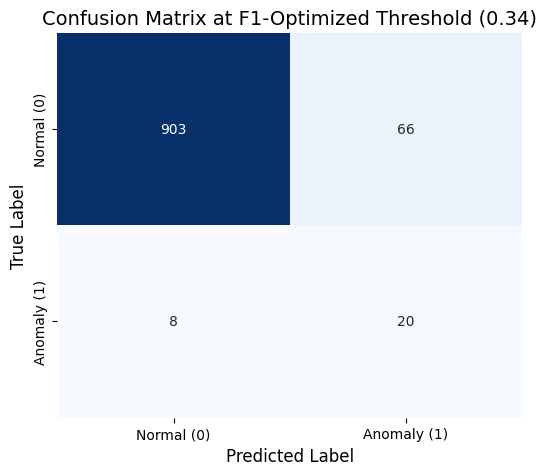

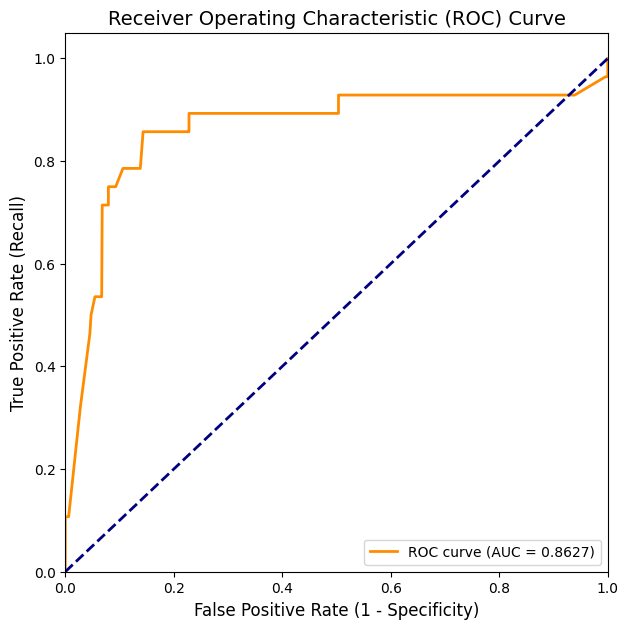

In [29]:
# ----------------------------------------------------
# 6. FORMAL EVALUATION
# ----------------------------------------------------

# VISUALIZATION FUNCTIONS

def plot_confusion_matrix(y_true, y_pred, title='Confusion Matrix'):
    """Plots a heatmap of the Confusion Matrix."""
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(6, 5))
    sns.heatmap(
        cm, 
        annot=True, 
        fmt='d', 
        cmap='Blues', 
        cbar=False,
        xticklabels=['Normal (0)', 'Anomaly (1)'],
        yticklabels=['Normal (0)', 'Anomaly (1)']
    )
    plt.title(title, fontsize=14)
    plt.ylabel('True Label', fontsize=12)
    plt.xlabel('Predicted Label', fontsize=12)
    plt.show()


def plot_roc_curve(y_true, y_scores, roc_auc):
    """Plots the Receiver Operating Characteristic (ROC) curve."""
    # Ensure y_scores are in the correct format (higher score = more positive class, 1)
    fpr, tpr, thresholds = roc_curve(y_true, y_scores)
    
    plt.figure(figsize=(7, 7))
    plt.plot(
        fpr, tpr, 
        color='darkorange', 
        lw=2, 
        label=f'ROC curve (AUC = {roc_auc:.4f})'
    )
    # Baseline random classifier line
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate (1 - Specificity)', fontsize=12)
    plt.ylabel('True Positive Rate (Recall)', fontsize=12)
    plt.title('Receiver Operating Characteristic (ROC) Curve', fontsize=14)
    plt.legend(loc="lower right")
    plt.show()
    
    
pred_labels = valid_conduct['Predicted_Anomaly']

# --- A. Metric Calculation (Same as before) ---
precision = precision_score(true_labels, pred_labels, zero_division=0)
recall = recall_score(true_labels, pred_labels, zero_division=0)
roc_auc = roc_auc_score(true_labels, scores)

print("\n--- ANOMALY DETECTION EVALUATION (Out-of-Sample Runs) ---")
print(f"Optimal Anomaly Threshold (Score): {best_threshold:.4f}")
print("-" * 50)
print(f"Precision: {precision:.4f} (Correct Detections / All Detections)")
print(f"Recall:    {recall:.4f} (Detections / All True Anomalies)")
print(f"F1-Score:  {best_f1:.4f} (Best Balance of P/R)")
print(f"ROC AUC:   {roc_auc:.4f} (Model's overall ranking ability)")
print("-" * 50)
print("The model is evaluated on its ability to generalize to new runs.")

# --- B. Visualization Calls ---

# 1. Confusion Matrix
plot_confusion_matrix(
    y_true=true_labels, 
    y_pred=pred_labels, 
    title=f'Confusion Matrix at F1-Optimized Threshold ({best_threshold:.2f})'
)

# 2. ROC AUC Curve
plot_roc_curve(
    y_true=true_labels, 
    y_scores=scores, 
    roc_auc=roc_auc
)

### Continuous training set

In [30]:
# -----------------------------------------------
# 2. FIT THE HIERARCHICAL TIME SERIES MODEL
# -----------------------------------------------

# Define the ARIMA/SARIMA order parameters:
# (p, d, q) for ARIMA terms, (P, D, Q, s) for Seasonal terms
import pmdarima as pm

# The auto_arima function handles the grid search and AIC minimization automatically
model_auto = pm.auto_arima(
    y=y_train,              # The training parameter values
    start_p=1, max_p=3,     # Range for non-seasonal AR
    start_q=1, max_q=3,     # Range for non-seasonal MA
    d=None, D=None,         # Let the function decide the differencing (d)
    seasonal=False,         # Set seasonal=True and define your seasonal period 's_val'
    trace=True,             # Print results for each iteration
    error_action='ignore',
    suppress_warnings=True,
    stepwise=True           # Speeds up the search
)

# The optimal orders are then stored in model_auto.order and model_auto.seasonal_order
order_params = model_auto.order
seasonal_params = model_auto.seasonal_order # No seasonal components

print(f"Fitting SARIMAX model with order={order_params}, seasonal_order={seasonal_params} and Fixed Effects...")

try:
    Cont_model = sm.tsa.statespace.SARIMAX(
        endog=y_train,
        order=order_params,
        seasonal_order=seasonal_params,
        enforce_stationarity=False,
        enforce_invertibility=False 
    )

    Cont_results = Cont_model.fit(disp=False)
    print("\n--- SARIMAX Model Fitting Complete ---")
    
except Exception as e:
    print(f"SARIMAX Model fitting failed: {e}")
    exit()

c:\Users\kittyoomm\Desktop\Work@MTEC\PlateMon_data_analytics\.venv\Lib\site-packages\sklearn\utils\deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\kittyoomm\Desktop\Work@MTEC\PlateMon_data_analytics\.venv\Lib\site-packages\sklearn\utils\deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\kittyoomm\Desktop\Work@MTEC\PlateMon_data_analytics\.venv\Lib\site-packages\sklearn\utils\deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\kittyoomm\Desktop\Work@MTEC\PlateMon_data_analytics\.venv\Lib\site-packages\sklearn\utils\deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\kittyoomm\Desktop\Work@MTEC\Pla

Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=2275.177, Time=0.58 sec


c:\Users\kittyoomm\Desktop\Work@MTEC\PlateMon_data_analytics\.venv\Lib\site-packages\sklearn\utils\deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=3116.447, Time=0.36 sec


c:\Users\kittyoomm\Desktop\Work@MTEC\PlateMon_data_analytics\.venv\Lib\site-packages\sklearn\utils\deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=2546.977, Time=0.26 sec


c:\Users\kittyoomm\Desktop\Work@MTEC\PlateMon_data_analytics\.venv\Lib\site-packages\sklearn\utils\deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=2279.162, Time=0.28 sec


c:\Users\kittyoomm\Desktop\Work@MTEC\PlateMon_data_analytics\.venv\Lib\site-packages\sklearn\utils\deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(0,1,0)(0,0,0)[0]             : AIC=3114.448, Time=0.40 sec


c:\Users\kittyoomm\Desktop\Work@MTEC\PlateMon_data_analytics\.venv\Lib\site-packages\sklearn\utils\deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=2172.289, Time=0.58 sec


c:\Users\kittyoomm\Desktop\Work@MTEC\PlateMon_data_analytics\.venv\Lib\site-packages\sklearn\utils\deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=2220.083, Time=0.24 sec


c:\Users\kittyoomm\Desktop\Work@MTEC\PlateMon_data_analytics\.venv\Lib\site-packages\sklearn\utils\deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=2174.204, Time=1.42 sec


c:\Users\kittyoomm\Desktop\Work@MTEC\PlateMon_data_analytics\.venv\Lib\site-packages\sklearn\utils\deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=2174.057, Time=0.79 sec


c:\Users\kittyoomm\Desktop\Work@MTEC\PlateMon_data_analytics\.venv\Lib\site-packages\sklearn\utils\deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=2227.230, Time=0.75 sec


c:\Users\kittyoomm\Desktop\Work@MTEC\PlateMon_data_analytics\.venv\Lib\site-packages\sklearn\utils\deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=2187.450, Time=0.35 sec


c:\Users\kittyoomm\Desktop\Work@MTEC\PlateMon_data_analytics\.venv\Lib\site-packages\sklearn\utils\deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=2024.134, Time=2.55 sec


c:\Users\kittyoomm\Desktop\Work@MTEC\PlateMon_data_analytics\.venv\Lib\site-packages\sklearn\utils\deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(3,1,3)(0,0,0)[0] intercept   : AIC=1977.931, Time=4.42 sec


c:\Users\kittyoomm\Desktop\Work@MTEC\PlateMon_data_analytics\.venv\Lib\site-packages\sklearn\utils\deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(2,1,3)(0,0,0)[0] intercept   : AIC=2161.543, Time=2.64 sec


c:\Users\kittyoomm\Desktop\Work@MTEC\PlateMon_data_analytics\.venv\Lib\site-packages\sklearn\utils\deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(3,1,3)(0,0,0)[0]             : AIC=1971.422, Time=1.75 sec


c:\Users\kittyoomm\Desktop\Work@MTEC\PlateMon_data_analytics\.venv\Lib\site-packages\sklearn\utils\deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(2,1,3)(0,0,0)[0]             : AIC=2159.547, Time=0.91 sec


c:\Users\kittyoomm\Desktop\Work@MTEC\PlateMon_data_analytics\.venv\Lib\site-packages\sklearn\utils\deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(3,1,2)(0,0,0)[0]             : AIC=2022.144, Time=0.85 sec


c:\Users\kittyoomm\Desktop\Work@MTEC\PlateMon_data_analytics\.venv\Lib\site-packages\sklearn\utils\deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(2,1,2)(0,0,0)[0]             : AIC=2172.058, Time=0.62 sec

Best model:  ARIMA(3,1,3)(0,0,0)[0]          
Total fit time: 19.790 seconds
Fitting SARIMAX model with order=(3, 1, 3), seasonal_order=(0, 0, 0, 0) and Fixed Effects...


c:\Users\kittyoomm\Desktop\Work@MTEC\PlateMon_data_analytics\.venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\kittyoomm\Desktop\Work@MTEC\PlateMon_data_analytics\.venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)



--- SARIMAX Model Fitting Complete ---


In [31]:
# Store the prediction of the training set
train_conduct['Prediction'] = Hier_results.fittedvalues.reset_index(drop=True)
train_conduct['Predicted_conductivity'] = data_scaler.inverse_transform(train_conduct['Prediction'].values.reshape(-1, 1)) 
train_conduct

,index,conductivity,run_id,timestamp,stand_value,Prediction,Predicted_conductivity
0,0,56.17,JUL_22_1,2025-07-22 13:21:01,0.538548,0.000000,56.039518
1,1,56.17,JUL_22_1,2025-07-22 13:21:03,0.538548,0.570969,56.177855
2,2,56.39,JUL_22_1,2025-07-22 13:21:05,1.446572,0.425012,56.142492
3,3,56.32,JUL_22_1,2025-07-22 13:21:07,1.157655,1.581385,56.422663
4,4,56.39,JUL_22_1,2025-07-22 13:21:09,1.446572,0.737238,56.218139
...,...,...,...,...,...,...,...
2485,2485,56.17,JUL_22_7,2025-07-22 16:34:50,0.538548,0.568822,56.177335
2486,2486,56.03,JUL_22_7,2025-07-22 16:34:52,-0.039285,0.573266,56.178412
2487,2487,56.17,JUL_22_7,2025-07-22 16:34:54,0.538548,0.451106,56.148814
2488,2488,56.17,JUL_22_7,2025-07-22 16:34:56,0.538548,0.430966,56.143935


In [33]:
print("Starting Out-of-Sample Forecasting for Validation Runs...")
    
# Forecast: Generate out-of-sample prediction for the validation run
forecast_results = Cont_results.get_prediction(start=start_idx, end=end_idx)

# inverse-transform valid predictions
Cont_predictions = data_scaler.inverse_transform(
    forecast_results.predicted_mean.values.reshape(-1, 1)
).ravel()

# Store results (Absolute Error and True Labels)
valid_conduct['Predicted_conductivity'] = pd.DataFrame(data=Cont_predictions).set_index(valid_conduct.index)
valid_conduct['Residual'] = (valid_conduct['conductivity'] - valid_conduct['Predicted_conductivity'])
valid_conduct['Anomaly_Score'] = np.abs(valid_conduct['Residual'])

print(f"Forecasting complete. Total validation data points: {len(valid_conduct)}")

Starting Out-of-Sample Forecasting for Validation Runs...


c:\Users\kittyoomm\Desktop\Work@MTEC\PlateMon_data_analytics\.venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
c:\Users\kittyoomm\Desktop\Work@MTEC\PlateMon_data_analytics\.venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


ValueError: Length mismatch: Expected 498 rows, received array of length 997

In [ ]:
# Calculate the standard deviation of the absolute errors on the validation set
# We use the errors from the validation set itself to define the local noise level.
error_std = valid_conduct['Anomaly_Score'].std()

# Define a range of std_coef values to test (e.g., from 2.0 to 5.0)
std_coef_range = np.arange(2.0, 5.1, 0.2) 

best_f1 = -1
optimal_std_coef = None
results = []

for std_coef in std_coef_range:
    df = valid_conduct.copy()
    
    # 1. Calculate the fixed threshold for this std_coef
    threshold = std_coef * error_std
    
    # 2. Classify points: 1 if error > threshold, 0 otherwise
    df['Predicted_Anomaly'] = (df['Anomaly_Score'] > threshold).astype(int)
    
    # 3. Calculate metrics against the true anomaly labels
    # True labels: df['anomaly_label']
    # Predicted labels: df['predicted_anomaly']
    
    f1 = f1_score(df['anomaly_label'], df['Predicted_Anomaly'])
    precision = precision_score(df['anomaly_label'], df['Predicted_Anomaly'], zero_division=0)
    recall = recall_score(df['anomaly_label'], df['Predicted_Anomaly'])
    
    results.append({
        'std_coef': std_coef,
        'threshold': threshold,
        'F1_Score': f1,
        'Precision': precision,
        'Recall': recall
    })
    
    # 4. Track the optimal coefficient
    if f1 > best_f1:
        best_f1 = f1
        optimal_std_coef = std_coef

print("--- Threshold Optimization Results ---")
results_df = pd.DataFrame(results).sort_values(by='F1_Score', ascending=False)
print(results_df)

print(f"\nOptimal Standard Deviation Coefficient: {optimal_std_coef:.2f}")
window = 100

# 1. Calculate Rolling Mean of Errors
rolling_mean_series = valid_conduct['Anomaly_score'].rolling(window=window).mean()

# 2. Calculate Rolling Standard Deviation of Errors
rolling_std_dev_series = valid_conduct['Anomaly_score'].rolling(window=window).std()

# 3. Calculate the Dynamic Threshold (Mean + Coefficient * Std Dev)
thresholds = rolling_mean_series + optimal_std_coef * rolling_std_dev_series

# 4. Assign to DataFrame and Display
valid_conduct['dynamic_threshold'] = thresholds

# You can now detect anomalies:
# valid_conduct['is_anomaly'] = valid_conduct['error'] > valid_conduct['dynamic_threshold']

# Display the DataFrame with the new threshold
valid_conduct

--- Threshold Optimization Results ---
    std_coef  threshold  F1_Score  Precision    Recall
7        3.4   0.789761  0.187500   0.750000  0.107143
4        2.8   0.650392  0.158730   0.102041  0.357143
6        3.2   0.743305  0.122449   0.142857  0.107143
2        2.4   0.557479  0.120968   0.068182  0.535714
3        2.6   0.603935  0.117155   0.066351  0.500000
5        3.0   0.696848  0.115385   0.125000  0.107143
1        2.2   0.511022  0.093664   0.050746  0.607143
0        2.0   0.464566  0.073913   0.039352  0.607143
8        3.6   0.836218  0.000000   0.000000  0.000000
9        3.8   0.882674  0.000000   0.000000  0.000000
10       4.0   0.929131  0.000000   0.000000  0.000000
11       4.2   0.975588  0.000000   0.000000  0.000000
12       4.4   1.022044  0.000000   0.000000  0.000000
13       4.6   1.068501  0.000000   0.000000  0.000000
14       4.8   1.114957  0.000000   0.000000  0.000000
15       5.0   1.161414  0.000000   0.000000  0.000000

Optimal Standard Deviatio

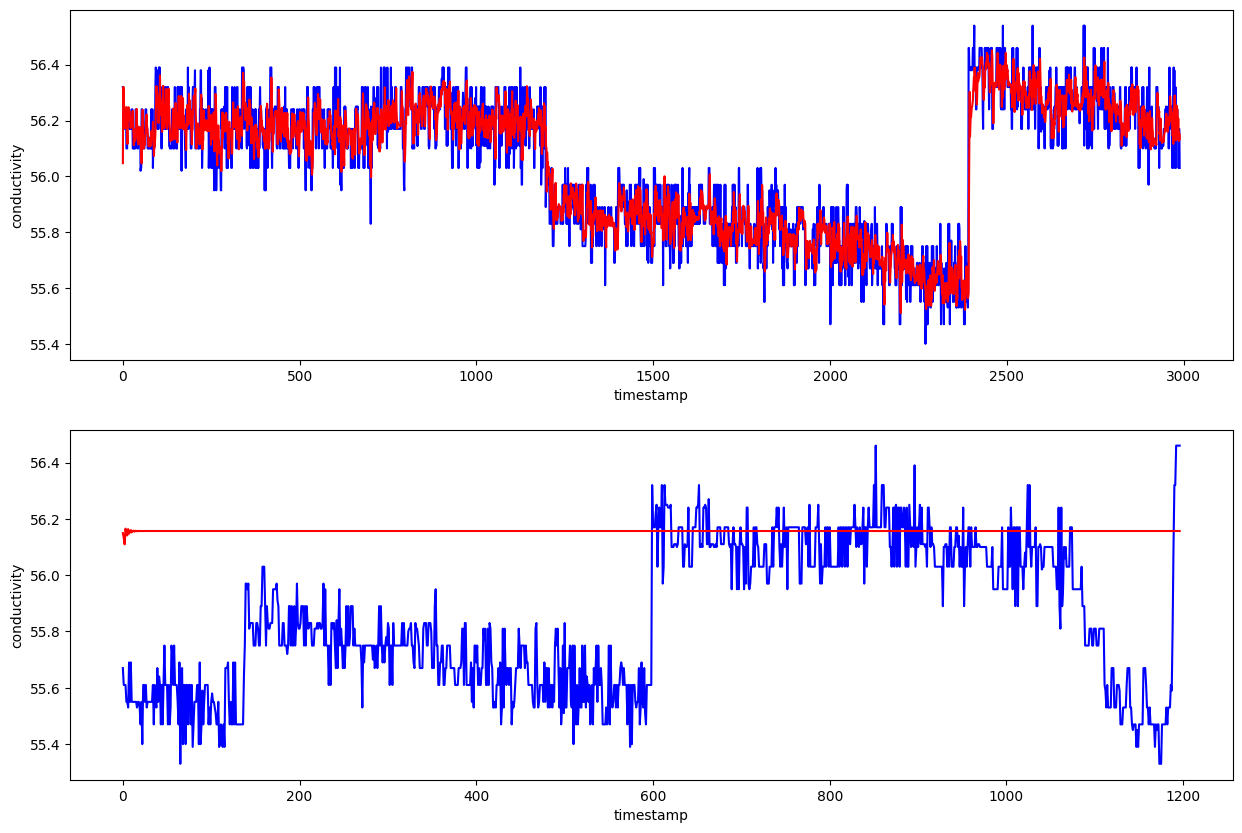

In [ ]:
# -----------------------------------------------
# 5. Data Visualization
# -----------------------------------------------

# Plot the results
fig, ax = plt.subplots(2, 1, figsize=(15, 10))
ax1 = sns.lineplot(data=train_conduct, x='index', y='conductivity', hue='run_id', palette=sns.color_palette("viridis"), ax=ax[0])
ax1 = sns.lineplot(data=train_conduct, x='index', y='Predicted_conductivity', color='orange', label='Predicted Conductivity', ax=ax[0])
ax1.set_title('Training Set: Conductivity Prediction')
ax1.set_xlabel('Timestamp')
ax1.set_ylabel('Conductivity')
ax1.legend()

ax2 = sns.lineplot(data=valid_conduct, x='index', y='conductivity', hue='run_id', palette=sns.color_palette("viridis"), ax=ax[1])
ax2 = sns.lineplot(data=valid_conduct, x='index', y='Predicted_conductivity', color='orange', label='Predicted Conductivity', ax=ax[1])
anomalies_labeled = valid_conduct[valid_conduct['anomaly_label'] == 1]
anomalies_labeled['anomaly_label'] = ['Labeled Anomaly']*len(anomalies_labeled)
print("Labeled Anomalies:")
print(anomalies_labeled[['index', 'conductivity']])
ax2 = sns.scatterplot(data=anomalies_labeled, x='index', y='conductivity', color='green', style='anomaly_label', markers='o', s=100, legend='full', ax=ax[1])
anomalies_detected = valid_conduct[valid_conduct['Predicted_Anomaly'] == 1]
anomalies_detected['Predicted_Anomaly'] = ['Detected Anomaly']*len(anomalies_detected)
print("Detected Anomalies:")
print(anomalies_detected[['index', 'conductivity']])
ax2 = sns.scatterplot(data=anomalies_detected, x='index', y='conductivity', color='red', style='Predicted_Anomaly',  markers='x', s=100, legend='full', ax=ax[1])

ax2.set_title('Validation Set: Conductivity Prediction with Labeled and Detected Anomalies')
ax2.set_xlabel('Timestamp')
ax2.set_ylabel('Conductivity')
ax2.legend()

plt.show()

match_anomalies = pd.merge(anomalies_labeled, anomalies_detected, how='inner', on=['index', 'conductivity'])
print("Matched Anomalies between Labeled and Detected:")
print(match_anomalies[['index', 'conductivity']])

In [ ]:
def detect_anomalies(df, errors, pred_error_thresholds):
    df['error'] = errors
    df['upper_bound'] = pred_error_thresholds
    # Here we have for each value its own threshold
    indices = df.index[df['error'] >= df['upper_bound']].values.tolist()
    indices = [i for i in indices]
    return indices

valid_anomalies_idxs = detect_anomalies(
    valid_conduct, valid_conduct['error'], valid_conduct['dynamic_threshold']
)

valid_anomalies_idxs

[271, 852, 928, 952, 1061, 1089, 1090, 1091, 1113]

In [ ]:
valid_conduct_anomaly_predict = valid_conduct.copy().iloc[valid_anomalies_idxs, :]
valid_conduct_anomaly = valid_conduct.copy()[valid_conduct['anomaly_label'] == 1]
valid_conduct_anomaly_predict

,timestamp,conductivity,anomaly_label,stand_value,predict,predicted_mean,predict_orig,error,dynamic_threshold,upper_bound
271,271,55.53,0,-2.161902,0.371312,0.458456,56.156802,0.626802,0.604020,0.604020
852,852,56.46,0,1.725981,0.770421,0.458456,56.156802,0.303198,0.251401,0.251401
928,928,55.89,0,-0.656915,0.752410,0.458456,56.156802,0.266802,0.242497,0.242497
952,952,55.89,0,-0.656915,0.207530,0.458456,56.156802,0.266802,0.252187,0.252187
1061,1061,55.81,0,-0.991356,0.990647,0.458456,56.156802,0.346802,0.326113,0.326113
1089,1089,55.75,0,-1.242188,0.809135,0.458456,56.156802,0.406802,0.375594,0.375594
1090,1090,55.75,0,-1.242188,0.792070,0.458456,56.156802,0.406802,0.389266,0.389266
1091,1091,55.75,0,-1.242188,0.751001,0.458456,56.156802,0.406802,0.402222,0.402222
1113,1113,55.53,0,-2.161902,0.818676,0.458456,56.156802,0.626802,0.596497,0.596497


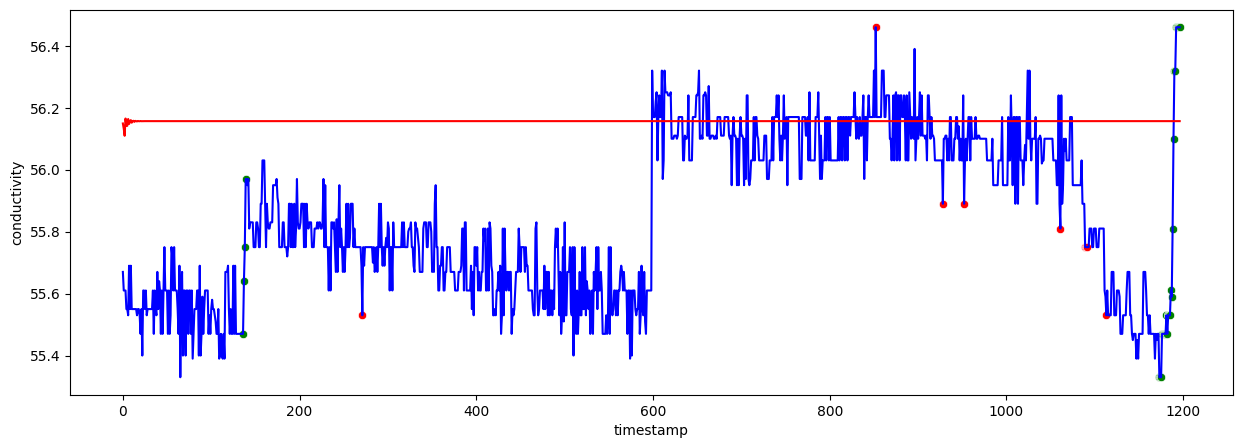

In [ ]:
# Data visualization
fig, ax = plt.subplots(figsize=(15, 5))
ax = sns.lineplot(data=valid_conduct, x='timestamp', y='conductivity', color='blue')
ax = sns.lineplot(data=valid_conduct, x='timestamp', y='predict_orig', color='red', markers='-')
ax = sns.scatterplot(data=valid_conduct_anomaly_predict, x='timestamp', y='conductivity', color='red', sizes=100)
ax = sns.scatterplot(data=valid_conduct_anomaly, x='timestamp', y='conductivity', color='green', sizes=10)

plt.show()

In [ ]:
valid_conf_matrix, *valid_metrics = calculate_metrics(
    valid_conduct, valid_anomalies_idxs
)

print(f'Valid:\n Precision: {valid_metrics[0]:.3f}\n' 
      f'Recall: {valid_metrics[1]:.3f}\n' 
      f'F1 score: {valid_metrics[2]:.3f}')

Valid:
 Precision: 0.000
Recall: 0.000
F1 score: 0.000
